In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Subset
from torch.utils.data import DataLoader, TensorDataset

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

In [2]:
# Define the path where the MNIST data will be downloaded
image_path = './local_training_data'

# Define a transform to convert the images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Download the MNIST training dataset
mnist_dataset = torchvision.datasets.MNIST(
    root=image_path, 
    train=True, 
    transform=transform, 
    download=True
)

# Split the dataset into training and validation sets
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))

# Download the MNIST test dataset
mnist_test_dataset = torchvision.datasets.MNIST(
    root=image_path, 
    train=False, 
    transform=transform, 
    download=False  # Set to False assuming it's already downloaded
)

In [3]:
# Assuming mnist_train_dataset and mnist_valid_dataset are already defined
train_ds = mnist_train_dataset
valid_ds = mnist_valid_dataset

In [4]:
# Initialize the sequential model
model = nn.Sequential()

# Add the first convolutional layer
model.add_module('conv1', nn.Conv2d(
    in_channels=1, 
    out_channels=32, 
    kernel_size=5, 
    padding=2
))

# Add a ReLU activation layer
model.add_module('relu1', nn.ReLU())

# Add the first pooling layer
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))

# Add the second convolutional layer
model.add_module('conv2', nn.Conv2d(
    in_channels=32, 
    out_channels=64, 
    kernel_size=5, 
    padding=2
))

# Add another ReLU activation layer
model.add_module('relu2', nn.ReLU())

# Add the second pooling layer
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

# Add a flatten layer to the model
model.add_module('flatten', nn.Flatten())

# Add fully connected layers with a dropout layer in between
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, 10))

In [7]:
def fit_model(model: torch.nn.Module,
                train_ds: TensorDataset,
                loss_fn: nn.Module,
                optimizer: optim.Optimizer,
                valid_ds: TensorDataset,
                accuracy_fn = None,
                num_epochs = 100,
                batch_size = 32,
                seed = 1,
                transform_pred = None,
                device: torch.device = "cpu"):
    # variables
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs    
    torch.manual_seed(seed)
    train_dl = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
    valid_dl = None
    if valid_ds:
        valid_dl = DataLoader(dataset=valid_ds, batch_size=batch_size, shuffle=True)
    n_train = len(train_dl.dataset)    
    # set model to device
    model.to(device)
    for epoch in range(num_epochs):
        # set model to training mode
        model.train()
        # mini-batch training
        for x_batch, y_batch in train_dl:
            # Send data to device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward pass
            y_pred = model(x_batch)
            if transform_pred:
                y_pred = transform_pred(y_pred)

            # Compute loss
            loss = loss_fn(y_pred, y_batch)

            # Do backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if accuracy_fn:
                accuracy_batch = accuracy_fn(y_pred, y_batch)
                accuracy_hist_train[epoch] += accuracy_batch
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)

        # Compute store loss and accuracy as percent
        loss_hist_train[epoch] /= n_train
        accuracy_hist_train[epoch] /= n_train
        
        if valid_dl:
            n_valid = len(valid_dl.dataset)
            # set model to training mode
            model.eval()
            with torch.no_grad():
                for x_batch, y_batch in valid_dl:                    
                    # Send data to device
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                    # Forward pass
                    y_pred = model(x_batch)
                    if transform_pred:
                        y_pred = transform_pred(y_pred)

                    # Compute loss
                    loss = loss_fn(y_pred, y_batch)

                    if accuracy_fn:
                        accuracy_batch = accuracy_fn(y_pred, y_batch)
                        accuracy_hist_valid[epoch] += accuracy_batch
                    loss_hist_valid[epoch] += loss.item()*y_batch.size(0)

                # Compute store loss and accuracy valid as percent
                accuracy_hist_valid[epoch] /= n_valid
                loss_hist_valid[epoch] /= n_valid
                    
        # Print out
        if epoch % 10 == 0:
            if valid_dl:
                print(f"Train loss: {loss_hist_train[epoch]:.5f} | Train accuracy: {accuracy_hist_train[epoch]:.2f}% | Val loss: {loss_hist_valid[epoch]:.5f} | Val accuracy: {accuracy_hist_valid[epoch]:.2f}%")
            else:
                print(f"Train loss: {loss_hist_train[epoch]:.5f} | Train accuracy: {accuracy_hist_train[epoch]:.2f}%")

    # Return result    
    return (loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid)

In [6]:
def get_accuracy_sum_multiclass(y_pred, y):
    is_correct = (torch.argmax(y_pred, dim=1) == y).float()
    accuracy = is_correct.sum()
    return accuracy

In [8]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid = fit_model(model, 
                                                                                       train_ds,
                                                                                       loss_fn, 
                                                                                       optimizer,
                                                                                       valid_ds=valid_ds,
                                                                                       num_epochs = 20,
                                                                                       batch_size=64, 
                                                                                       accuracy_fn=get_accuracy_sum_multiclass)

Train loss: 0.00209 | Train accuracy: 1.00% | Val loss: 0.05216 | Val accuracy: 0.99%
Train loss: 0.00229 | Train accuracy: 1.00% | Val loss: 0.06804 | Val accuracy: 0.99%


In [14]:
def plot_learning_curve(loss_hist_train, accuracy_hist_train, loss_hist_valid = None, accuracy_hist_valid = None, loss_title='Loss', accuracy_title='Accuracy'):
    # Visualization setup
    loss_legend = ['Train Loss']
    acc_legend = ['Train Acc']
    fig = plt.figure(figsize=(16, 4))

    # Plot for training loss
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(loss_hist_train, lw=4)
    if loss_hist_valid:
        ax.plot(loss_hist_valid, lw=4)
        loss_legend.append('Valid Loss')
    ax.legend(loss_legend)
    ax.set_title(loss_title, size=15)
    ax.set_xlabel('Epoch', size=15)
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Plot for training accuracy
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(accuracy_hist_train, lw=4)
    if accuracy_hist_valid:
        ax.plot(accuracy_hist_valid, lw=4)
        acc_legend.append('Valid Acc')
    ax.legend(acc_legend)
    ax.set_title(accuracy_title, size=15)
    ax.set_xlabel('Epoch', size=15)
    ax.tick_params(axis='both', which='major', labelsize=15)

    plt.show()

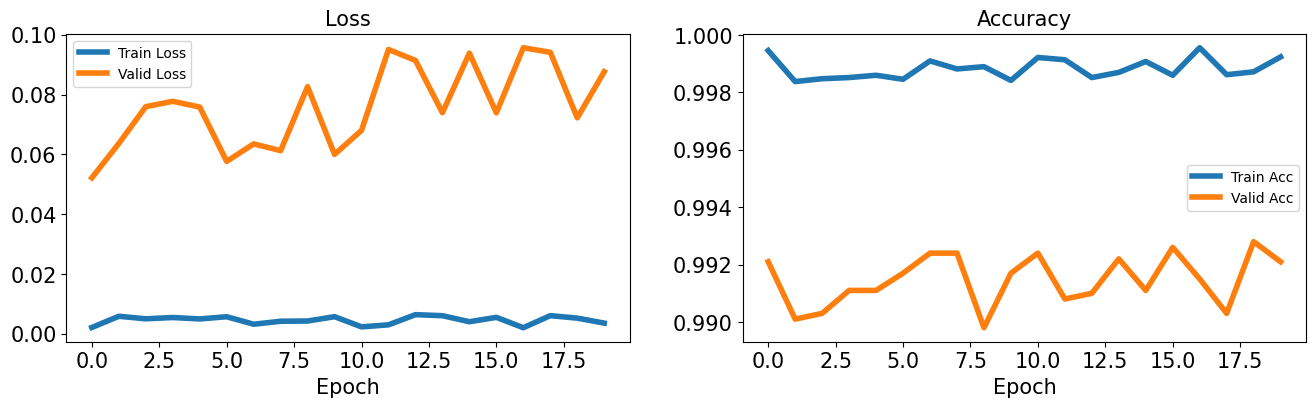

In [15]:
# plot the learning curve
plot_learning_curve(loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid)

In [16]:
test_ds = mnist_valid_dataset

In [17]:
def evaluate_model(model: torch.nn.Module,
                    test_ds: TensorDataset,
                    score_fn,
                    batch_size = 32,
                    transform_pred = None,
                    device: torch.device = "cpu"):
    # variables
    score = 0
    test_dl = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=True)
    n_test = len(test_dl.dataset)
    # set to device
    model.to(device)
    # logic
    with torch.no_grad():
        for x_batch, y_batch in test_dl:
            # Send data to device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward pass
            y_pred = model(x_batch)
            if transform_pred:
                y_pred = transform_pred(y_pred)

            # Compute the score
            score += score_fn(y_pred, y_batch)

        # Compute the final score
        score = score / n_test
    # result
    return score

In [18]:
score = evaluate_model(model, test_ds, get_accuracy_sum_multiclass)
print(score)

tensor(0.9921)


In [39]:
x_item, y_item = test_ds[0]
print(x_item.shape)
print(y_item)
x_item = x_item.unsqueeze(0)
print(x_item.shape)

torch.Size([1, 28, 28])
5
torch.Size([1, 1, 28, 28])


In [40]:
def predict_multiclass(y_pred):
    return torch.argmax(y_pred, dim=1)

In [41]:
y_pred = model(x_item)
y_pred = predict_multiclass(y_pred)
print(y_pred)

tensor([5])
